# Siamese Networks for Speaker Identification

Base code is leveraged from https://hackernoon.com/one-shot-learning-with-siamese-networks-in-pytorch-8ddaab10340e

In [1]:
%matplotlib inline
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import random
from PIL import Image
import torch
from torch.autograd import Variable
import PIL.ImageOps    
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

In [2]:
def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

## Configuration Class
A simple class to manage configuration

In [4]:
class Config():
    base_dir = "something"
    training_dir = base_dir + "train_data/"
    testing_dir = base_dir + "test_data/"
    train_batch_size = 64
    train_number_epochs = 10

## Custom Dataset Class
This dataset generates a pair of images. 0 for geniune pair and 1 for imposter pair

In [5]:
class SiameseNetworkDataset(Dataset):
    
    def __init__(self,imageFolderDataset,transform=None,should_invert=True):
        self.imageFolderDataset = imageFolderDataset    
        self.transform = transform
        self.should_invert = should_invert
        
    def __getitem__(self,index):
        img0_tuple = random.choice(self.imageFolderDataset.imgs)
        #we need to make sure approx 50% of images are in the same class
        should_get_same_class = random.randint(0,1) 
        if should_get_same_class:
            while True:
                #keep looping till the same class image is found
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1]==img1_tuple[1]:
                    break
        else:
            while True:
                #keep looping till a different class image is found
                
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1] !=img1_tuple[1]:
                    break

        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])
        img0 = img0.convert("L")
        img1 = img1.convert("L")
        
        if self.should_invert:
            img0 = PIL.ImageOps.invert(img0)
            img1 = PIL.ImageOps.invert(img1)

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        
        return img0, img1 , torch.from_numpy(np.array([int(img1_tuple[1]!=img0_tuple[1])],dtype=np.float32))
    
    def __len__(self):
        return len(self.imageFolderDataset.imgs)

## Using Image Folder Dataset

In [6]:
folder_dataset = dset.ImageFolder(root=Config.training_dir)

In [7]:
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset,
                                        transform=transforms.Compose([#transforms.Resize((227,227)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       ,should_invert=False)

## Visualising some of the data
The top row and the bottom row of any column is one pair. The 0s and 1s correspond to the column of the image.
1 indiciates dissimilar, and 0 indicates similar.

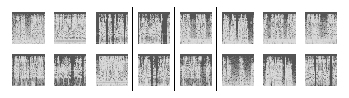

[[1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]]


In [8]:
vis_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=8)
dataiter = iter(vis_dataloader)


example_batch = next(dataiter)
concatenated = torch.cat((example_batch[0],example_batch[1]),0)
imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy())

## Neural Net Definition
We will use a standard convolutional neural network

In [9]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.cnn1 = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(1, 4, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(4),
            
            nn.ReflectionPad2d(1),
            nn.Conv2d(4, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),


            nn.ReflectionPad2d(1),
            nn.Conv2d(8, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),


        )

        self.fc1 = nn.Sequential(
            nn.Linear(8*227*227, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 5))

    def forward_once(self, x):
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2

## Contrastive Loss

In [10]:
class ContrastiveLoss(torch.nn.Module):
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        return loss_contrastive

In [34]:
ContrastiveLoss()

ContrastiveLoss()

## Training Time!

In [13]:
Config.train_batch_size

64

In [11]:
train_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=Config.train_batch_size)

In [12]:
net = SiameseNetwork()#.cuda()
criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(),lr = 0.0005 )

In [14]:
counter = []
loss_history = [] 
iteration_number= 0

In [15]:
def train(model, device, train_loader, epoch):
    model.train()
    losses = []
    len_train_loader = len(train_loader)
    for batch_idx, (data0, data1, label) in enumerate(tqdm.tqdm(train_loader)): #tqdm.tqdm(train_loader)
        #data, label = data.to(device), label.to(device)
        optimizer.zero_grad()
        out0, out1 = model(data0, data1)
        loss_contrastive = criterion(out0, out1, label)
        loss_contrastive.backward()
        losses.append(loss_contrastive.item())

        optimizer.step()
        if batch_idx % 5 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, (batch_idx+1) * len(data0), len(train_loader.dataset),
                100. * (batch_idx+1) / len(train_loader), loss_contrastive.item()))
    train_loss = np.mean(losses)
    print('\nTrain set: Average loss: {:.4f}\n'.format(train_loss))
    return train_loss

In [16]:
folder_dataset_test = dset.ImageFolder(root=Config.testing_dir)
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset_test,
                                        transform=transforms.Compose([#transforms.Resize((100,100)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       ,should_invert=False)

test_dataloader = DataLoader(siamese_dataset,num_workers=6,batch_size=32,shuffle=True) #batch_size=1

In [17]:
def test(model, device, test_loader):
    model.eval()
    with torch.no_grad():
        loss = 0
        for batch_idx, (data0, data1, label) in enumerate(tqdm.tqdm(test_loader)):
            out0, out1 = model(data0, data1)
            loss += criterion(out0, out1, label).item()
    loss /= len(test_loader)
    print('\nTest set: Average loss: {:.4f}\n'.format(loss))
    return loss

In [18]:
EPOCHS = 20

In [19]:
import tqdm
import time

In [20]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [31]:
len(test_dataloader)

18

In [32]:
len(train_dataloader)

25

In [21]:
test(net, device, test_dataloader)

100%|██████████| 18/18 [00:20<00:00,  1.13s/it]


Test set: Average loss: 1.9177



1.9177444577217102

In [22]:
train_losses = []
test_losses = []
for epoch in range(0, EPOCHS):
    print("Epoch number: ", epoch)
    #lr = LEARNING_RATE * np.power(0.25, (int(epoch / 6)))
    start_time = time.time()
    print("\nTraining:")
    train_loss = train(net, device, train_dataloader, epoch)
    print("\nTesting:")
    test_loss = test(net, device, test_dataloader)
    train_losses.append((epoch, train_loss))
    test_losses.append((epoch, test_loss))
    end_time = time.time()
    print("Time taken for running epoch {} is {:.3f} seconds.\n\n".format(epoch, end_time-start_time))

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch number:  0

Training:


  4%|▍         | 1/25 [00:23<09:19, 23.32s/it]

Train Epoch: 0 [64/1557 (4%)]	Loss: 1.704338


 24%|██▍       | 6/25 [02:20<06:41, 21.14s/it]

Train Epoch: 0 [384/1557 (24%)]	Loss: 8.694440


 44%|████▍     | 11/25 [03:56<04:42, 20.16s/it]

Train Epoch: 0 [704/1557 (44%)]	Loss: 10.867376


 64%|██████▍   | 16/25 [05:44<03:04, 20.49s/it]

Train Epoch: 0 [1024/1557 (64%)]	Loss: 4.283262


 84%|████████▍ | 21/25 [07:06<01:09, 17.31s/it]

Train Epoch: 0 [1344/1557 (84%)]	Loss: 4.256571


  0%|          | 0/18 [00:00<?, ?it/s]


Train set: Average loss: 11.6968


Testing:


  0%|          | 0/25 [00:00<?, ?it/s]


Test set: Average loss: 10.1164

Time taken for running epoch 0 is 538.994 seconds.


Epoch number:  1

Training:


  4%|▍         | 1/25 [00:34<13:57, 34.88s/it]

Train Epoch: 1 [64/1557 (4%)]	Loss: 2.514049


 24%|██▍       | 6/25 [03:00<08:16, 26.12s/it]

Train Epoch: 1 [384/1557 (24%)]	Loss: 2.051464


 44%|████▍     | 11/25 [04:50<04:51, 20.84s/it]

Train Epoch: 1 [704/1557 (44%)]	Loss: 1.000976


 64%|██████▍   | 16/25 [06:38<03:11, 21.28s/it]

Train Epoch: 1 [1024/1557 (64%)]	Loss: 1.012600


 84%|████████▍ | 21/25 [08:41<01:39, 24.78s/it]

Train Epoch: 1 [1344/1557 (84%)]	Loss: 1.056408


  0%|          | 0/18 [00:00<?, ?it/s]


Train set: Average loss: 1.5511


Testing:


  0%|          | 0/25 [00:00<?, ?it/s]


Test set: Average loss: 5.8645

Time taken for running epoch 1 is 659.504 seconds.


Epoch number:  2

Training:


  4%|▍         | 1/25 [01:36<38:43, 96.81s/it]

Train Epoch: 2 [64/1557 (4%)]	Loss: 1.149692


 24%|██▍       | 6/25 [04:05<12:19, 38.91s/it]

Train Epoch: 2 [384/1557 (24%)]	Loss: 0.886207


 44%|████▍     | 11/25 [07:03<08:10, 35.06s/it]

Train Epoch: 2 [704/1557 (44%)]	Loss: 0.912418


 64%|██████▍   | 16/25 [09:29<04:21, 29.09s/it]

Train Epoch: 2 [1024/1557 (64%)]	Loss: 0.767618


 84%|████████▍ | 21/25 [12:01<02:09, 32.34s/it]

Train Epoch: 2 [1344/1557 (84%)]	Loss: 0.498362


  0%|          | 0/18 [00:00<?, ?it/s]


Train set: Average loss: 0.8199


Testing:


  0%|          | 0/25 [00:00<?, ?it/s]


Test set: Average loss: 1.3265

Time taken for running epoch 2 is 854.201 seconds.


Epoch number:  3

Training:


  4%|▍         | 1/25 [00:34<13:52, 34.69s/it]

Train Epoch: 3 [64/1557 (4%)]	Loss: 0.475826


 24%|██▍       | 6/25 [02:46<08:18, 26.23s/it]

Train Epoch: 3 [384/1557 (24%)]	Loss: 0.625472


 44%|████▍     | 11/25 [04:53<05:33, 23.83s/it]

Train Epoch: 3 [704/1557 (44%)]	Loss: 0.747330


 64%|██████▍   | 16/25 [06:41<03:13, 21.53s/it]

Train Epoch: 3 [1024/1557 (64%)]	Loss: 0.560272


 84%|████████▍ | 21/25 [08:32<01:29, 22.37s/it]

Train Epoch: 3 [1344/1557 (84%)]	Loss: 0.549821


  0%|          | 0/18 [00:00<?, ?it/s]


Train set: Average loss: 0.5311


Testing:


  0%|          | 0/25 [00:00<?, ?it/s]


Test set: Average loss: 1.0967

Time taken for running epoch 3 is 605.330 seconds.


Epoch number:  4

Training:


  4%|▍         | 1/25 [00:35<14:12, 35.50s/it]

Train Epoch: 4 [64/1557 (4%)]	Loss: 0.407830


 24%|██▍       | 6/25 [02:44<07:54, 24.98s/it]

Train Epoch: 4 [384/1557 (24%)]	Loss: 0.412729


 44%|████▍     | 11/25 [04:16<04:35, 19.65s/it]

Train Epoch: 4 [704/1557 (44%)]	Loss: 0.360019


 64%|██████▍   | 16/25 [05:52<02:49, 18.88s/it]

Train Epoch: 4 [1024/1557 (64%)]	Loss: 0.358561


 84%|████████▍ | 21/25 [07:27<01:15, 18.91s/it]

Train Epoch: 4 [1344/1557 (84%)]	Loss: 0.250454


  0%|          | 0/18 [00:00<?, ?it/s]


Train set: Average loss: 0.4005


Testing:


  0%|          | 0/25 [00:00<?, ?it/s]


Test set: Average loss: 1.0055

Time taken for running epoch 4 is 537.330 seconds.


Epoch number:  5

Training:


  4%|▍         | 1/25 [00:42<16:49, 42.05s/it]

Train Epoch: 5 [64/1557 (4%)]	Loss: 0.317235


 24%|██▍       | 6/25 [02:44<08:05, 25.55s/it]

Train Epoch: 5 [384/1557 (24%)]	Loss: 0.193720


 44%|████▍     | 11/25 [04:25<04:58, 21.29s/it]

Train Epoch: 5 [704/1557 (44%)]	Loss: 0.363791


 64%|██████▍   | 16/25 [06:12<03:05, 20.57s/it]

Train Epoch: 5 [1024/1557 (64%)]	Loss: 0.251287


 84%|████████▍ | 21/25 [08:04<01:29, 22.47s/it]

Train Epoch: 5 [1344/1557 (84%)]	Loss: 0.287238


  0%|          | 0/18 [00:00<?, ?it/s]


Train set: Average loss: 0.2877


Testing:


  0%|          | 0/25 [00:00<?, ?it/s]


Test set: Average loss: 1.0804

Time taken for running epoch 5 is 585.739 seconds.


Epoch number:  6

Training:


  4%|▍         | 1/25 [00:41<16:47, 41.98s/it]

Train Epoch: 6 [64/1557 (4%)]	Loss: 0.261727


 24%|██▍       | 6/25 [02:49<08:24, 26.53s/it]

Train Epoch: 6 [384/1557 (24%)]	Loss: 0.208642


 44%|████▍     | 11/25 [04:25<04:43, 20.21s/it]

Train Epoch: 6 [704/1557 (44%)]	Loss: 0.198961


 64%|██████▍   | 16/25 [06:09<03:08, 20.96s/it]

Train Epoch: 6 [1024/1557 (64%)]	Loss: 0.118207


 84%|████████▍ | 21/25 [07:46<01:18, 19.66s/it]

Train Epoch: 6 [1344/1557 (84%)]	Loss: 0.164550


  0%|          | 0/18 [00:00<?, ?it/s]


Train set: Average loss: 0.1861


Testing:


  0%|          | 0/25 [00:00<?, ?it/s]


Test set: Average loss: 0.9486

Time taken for running epoch 6 is 553.249 seconds.


Epoch number:  7

Training:


  4%|▍         | 1/25 [00:31<12:42, 31.76s/it]

Train Epoch: 7 [64/1557 (4%)]	Loss: 0.162176


 24%|██▍       | 6/25 [02:43<07:43, 24.40s/it]

Train Epoch: 7 [384/1557 (24%)]	Loss: 0.149734


 44%|████▍     | 11/25 [04:28<04:50, 20.75s/it]

Train Epoch: 7 [704/1557 (44%)]	Loss: 0.113691


 64%|██████▍   | 16/25 [06:01<02:49, 18.82s/it]

Train Epoch: 7 [1024/1557 (64%)]	Loss: 0.135991


 84%|████████▍ | 21/25 [07:36<01:17, 19.29s/it]

Train Epoch: 7 [1344/1557 (84%)]	Loss: 0.137987


  0%|          | 0/18 [00:00<?, ?it/s]


Train set: Average loss: 0.1461


Testing:


  0%|          | 0/25 [00:00<?, ?it/s]


Test set: Average loss: 0.9264

Time taken for running epoch 7 is 559.434 seconds.


Epoch number:  8

Training:


  4%|▍         | 1/25 [00:32<12:50, 32.11s/it]

Train Epoch: 8 [64/1557 (4%)]	Loss: 0.140326


 24%|██▍       | 6/25 [02:48<08:12, 25.94s/it]

Train Epoch: 8 [384/1557 (24%)]	Loss: 0.087626


 44%|████▍     | 11/25 [04:33<05:02, 21.62s/it]

Train Epoch: 8 [704/1557 (44%)]	Loss: 0.096872


 64%|██████▍   | 16/25 [06:05<02:53, 19.25s/it]

Train Epoch: 8 [1024/1557 (64%)]	Loss: 0.103316


 84%|████████▍ | 21/25 [07:40<01:17, 19.25s/it]

Train Epoch: 8 [1344/1557 (84%)]	Loss: 0.098754


  0%|          | 0/18 [00:00<?, ?it/s]


Train set: Average loss: 0.1072


Testing:


  0%|          | 0/25 [00:00<?, ?it/s]


Test set: Average loss: 1.0626

Time taken for running epoch 8 is 556.259 seconds.


Epoch number:  9

Training:


  4%|▍         | 1/25 [00:30<12:18, 30.78s/it]

Train Epoch: 9 [64/1557 (4%)]	Loss: 0.106477


 24%|██▍       | 6/25 [02:39<07:57, 25.13s/it]

Train Epoch: 9 [384/1557 (24%)]	Loss: 0.071798


 44%|████▍     | 11/25 [04:09<04:30, 19.32s/it]

Train Epoch: 9 [704/1557 (44%)]	Loss: 0.075818


 64%|██████▍   | 16/25 [05:46<02:48, 18.74s/it]

Train Epoch: 9 [1024/1557 (64%)]	Loss: 0.094367


 84%|████████▍ | 21/25 [07:28<01:20, 20.04s/it]

Train Epoch: 9 [1344/1557 (84%)]	Loss: 0.077610


  0%|          | 0/18 [00:00<?, ?it/s]


Train set: Average loss: 0.0811


Testing:


  0%|          | 0/25 [00:00<?, ?it/s]


Test set: Average loss: 1.0102

Time taken for running epoch 9 is 553.660 seconds.


Epoch number:  10

Training:


  4%|▍         | 1/25 [00:37<15:01, 37.56s/it]

Train Epoch: 10 [64/1557 (4%)]	Loss: 0.086519


 24%|██▍       | 6/25 [02:30<07:38, 24.12s/it]

Train Epoch: 10 [384/1557 (24%)]	Loss: 0.068022


 44%|████▍     | 11/25 [04:05<04:39, 19.95s/it]

Train Epoch: 10 [704/1557 (44%)]	Loss: 0.060084


 64%|██████▍   | 16/25 [05:50<03:14, 21.60s/it]

Train Epoch: 10 [1024/1557 (64%)]	Loss: 0.056163


 84%|████████▍ | 21/25 [07:33<01:23, 20.88s/it]

Train Epoch: 10 [1344/1557 (84%)]	Loss: 0.060564


  0%|          | 0/18 [00:00<?, ?it/s]


Train set: Average loss: 0.0608


Testing:


  0%|          | 0/25 [00:00<?, ?it/s]


Test set: Average loss: 0.9466

Time taken for running epoch 10 is 552.774 seconds.


Epoch number:  11

Training:


  4%|▍         | 1/25 [00:39<15:57, 39.90s/it]

Train Epoch: 11 [64/1557 (4%)]	Loss: 0.040853


 24%|██▍       | 6/25 [02:41<07:52, 24.87s/it]

Train Epoch: 11 [384/1557 (24%)]	Loss: 0.075469


 44%|████▍     | 11/25 [04:22<05:00, 21.46s/it]

Train Epoch: 11 [704/1557 (44%)]	Loss: 0.045970


 64%|██████▍   | 16/25 [06:10<03:19, 22.21s/it]

Train Epoch: 11 [1024/1557 (64%)]	Loss: 0.034420


 84%|████████▍ | 21/25 [07:53<01:22, 20.52s/it]

Train Epoch: 11 [1344/1557 (84%)]	Loss: 0.026670


  0%|          | 0/18 [00:00<?, ?it/s]


Train set: Average loss: 0.0435


Testing:


  0%|          | 0/25 [00:00<?, ?it/s]


Test set: Average loss: 0.8961

Time taken for running epoch 11 is 560.389 seconds.


Epoch number:  12

Training:


  4%|▍         | 1/25 [00:35<14:22, 35.93s/it]

Train Epoch: 12 [64/1557 (4%)]	Loss: 0.040765


 24%|██▍       | 6/25 [02:34<07:45, 24.49s/it]

Train Epoch: 12 [384/1557 (24%)]	Loss: 0.028463


 44%|████▍     | 11/25 [04:08<04:37, 19.80s/it]

Train Epoch: 12 [704/1557 (44%)]	Loss: 0.036705


 64%|██████▍   | 16/25 [05:49<02:56, 19.64s/it]

Train Epoch: 12 [1024/1557 (64%)]	Loss: 0.031127


 84%|████████▍ | 21/25 [07:40<01:27, 21.91s/it]

Train Epoch: 12 [1344/1557 (84%)]	Loss: 0.028386


  0%|          | 0/18 [00:00<?, ?it/s]


Train set: Average loss: 0.0352


Testing:


  0%|          | 0/25 [00:00<?, ?it/s]


Test set: Average loss: 0.8727

Time taken for running epoch 12 is 550.316 seconds.


Epoch number:  13

Training:


  4%|▍         | 1/25 [00:36<14:34, 36.43s/it]

Train Epoch: 13 [64/1557 (4%)]	Loss: 0.031965


 24%|██▍       | 6/25 [03:05<08:35, 27.13s/it]

Train Epoch: 13 [384/1557 (24%)]	Loss: 0.020756


 44%|████▍     | 11/25 [04:42<04:50, 20.75s/it]

Train Epoch: 13 [704/1557 (44%)]	Loss: 0.023886


 64%|██████▍   | 16/25 [06:45<04:04, 27.12s/it]

Train Epoch: 13 [1024/1557 (64%)]	Loss: 0.031928


 84%|████████▍ | 21/25 [09:00<01:43, 25.80s/it]

Train Epoch: 13 [1344/1557 (84%)]	Loss: 0.027876


  0%|          | 0/18 [00:00<?, ?it/s]


Train set: Average loss: 0.0255


Testing:


  0%|          | 0/25 [00:00<?, ?it/s]


Test set: Average loss: 0.9522

Time taken for running epoch 13 is 640.413 seconds.


Epoch number:  14

Training:


  4%|▍         | 1/25 [00:39<15:41, 39.24s/it]

Train Epoch: 14 [64/1557 (4%)]	Loss: 0.021660


 24%|██▍       | 6/25 [03:58<13:39, 43.15s/it]

Train Epoch: 14 [384/1557 (24%)]	Loss: 0.021201


 44%|████▍     | 11/25 [08:04<09:42, 41.59s/it]

Train Epoch: 14 [704/1557 (44%)]	Loss: 0.025685


 64%|██████▍   | 16/25 [10:30<04:54, 32.76s/it]

Train Epoch: 14 [1024/1557 (64%)]	Loss: 0.018680


 84%|████████▍ | 21/25 [13:04<01:58, 29.66s/it]

Train Epoch: 14 [1344/1557 (84%)]	Loss: 0.024146


  0%|          | 0/18 [00:00<?, ?it/s]


Train set: Average loss: 0.0214


Testing:


  0%|          | 0/25 [00:00<?, ?it/s]


Test set: Average loss: 0.9809

Time taken for running epoch 14 is 913.219 seconds.


Epoch number:  15

Training:


  4%|▍         | 1/25 [00:51<20:41, 51.72s/it]

Train Epoch: 15 [64/1557 (4%)]	Loss: 0.017688


 24%|██▍       | 6/25 [03:17<09:21, 29.56s/it]

Train Epoch: 15 [384/1557 (24%)]	Loss: 0.015842


 44%|████▍     | 11/25 [05:32<05:49, 24.93s/it]

Train Epoch: 15 [704/1557 (44%)]	Loss: 0.022567


 64%|██████▍   | 16/25 [07:24<03:19, 22.12s/it]

Train Epoch: 15 [1024/1557 (64%)]	Loss: 0.011372


 84%|████████▍ | 21/25 [10:08<02:14, 33.71s/it]

Train Epoch: 15 [1344/1557 (84%)]	Loss: 0.014984


  0%|          | 0/18 [00:00<?, ?it/s]


Train set: Average loss: 0.0174


Testing:


  0%|          | 0/25 [00:00<?, ?it/s]


Test set: Average loss: 0.8020

Time taken for running epoch 15 is 760.481 seconds.


Epoch number:  16

Training:


  4%|▍         | 1/25 [00:53<21:30, 53.76s/it]

Train Epoch: 16 [64/1557 (4%)]	Loss: 0.023123


 24%|██▍       | 6/25 [03:19<09:56, 31.41s/it]

Train Epoch: 16 [384/1557 (24%)]	Loss: 0.014160


 44%|████▍     | 11/25 [05:14<05:35, 23.95s/it]

Train Epoch: 16 [704/1557 (44%)]	Loss: 0.011673


 64%|██████▍   | 16/25 [07:06<03:27, 23.05s/it]

Train Epoch: 16 [1024/1557 (64%)]	Loss: 0.011306


 84%|████████▍ | 21/25 [09:14<01:35, 23.79s/it]

Train Epoch: 16 [1344/1557 (84%)]	Loss: 0.015929


  0%|          | 0/18 [00:00<?, ?it/s]


Train set: Average loss: 0.0161


Testing:


  0%|          | 0/25 [00:00<?, ?it/s]


Test set: Average loss: 1.0569

Time taken for running epoch 16 is 645.386 seconds.


Epoch number:  17

Training:


  4%|▍         | 1/25 [00:41<16:42, 41.77s/it]

Train Epoch: 17 [64/1557 (4%)]	Loss: 0.023152


 24%|██▍       | 6/25 [02:55<08:33, 27.04s/it]

Train Epoch: 17 [384/1557 (24%)]	Loss: 0.015541


 44%|████▍     | 11/25 [05:03<06:11, 26.57s/it]

Train Epoch: 17 [704/1557 (44%)]	Loss: 0.017114


 64%|██████▍   | 16/25 [06:48<03:18, 22.11s/it]

Train Epoch: 17 [1024/1557 (64%)]	Loss: 0.016347


 84%|████████▍ | 21/25 [08:31<01:25, 21.38s/it]

Train Epoch: 17 [1344/1557 (84%)]	Loss: 0.011377


  0%|          | 0/18 [00:00<?, ?it/s]


Train set: Average loss: 0.0161


Testing:


  0%|          | 0/25 [00:00<?, ?it/s]


Test set: Average loss: 0.8693

Time taken for running epoch 17 is 619.785 seconds.


Epoch number:  18

Training:


  4%|▍         | 1/25 [00:38<15:26, 38.61s/it]

Train Epoch: 18 [64/1557 (4%)]	Loss: 0.014143


 24%|██▍       | 6/25 [03:28<11:21, 35.86s/it]

Train Epoch: 18 [384/1557 (24%)]	Loss: 0.015052


 44%|████▍     | 11/25 [05:23<05:32, 23.72s/it]

Train Epoch: 18 [704/1557 (44%)]	Loss: 0.011703


 64%|██████▍   | 16/25 [07:25<03:35, 23.98s/it]

Train Epoch: 18 [1024/1557 (64%)]	Loss: 0.014390


 84%|████████▍ | 21/25 [09:25<01:32, 23.18s/it]

Train Epoch: 18 [1344/1557 (84%)]	Loss: 0.015388


  0%|          | 0/18 [00:00<?, ?it/s]


Train set: Average loss: 0.0136


Testing:


  0%|          | 0/25 [00:00<?, ?it/s]


Test set: Average loss: 0.9000

Time taken for running epoch 18 is 660.369 seconds.


Epoch number:  19

Training:


  4%|▍         | 1/25 [00:38<15:21, 38.41s/it]

Train Epoch: 19 [64/1557 (4%)]	Loss: 0.011331


 24%|██▍       | 6/25 [04:21<13:25, 42.41s/it]

Train Epoch: 19 [384/1557 (24%)]	Loss: 0.013246


 44%|████▍     | 11/25 [06:48<07:18, 31.32s/it]

Train Epoch: 19 [704/1557 (44%)]	Loss: 0.010695


 64%|██████▍   | 16/25 [09:35<05:10, 34.54s/it]

Train Epoch: 19 [1024/1557 (64%)]	Loss: 0.016793


 84%|████████▍ | 21/25 [12:24<02:26, 36.71s/it]

Train Epoch: 19 [1344/1557 (84%)]	Loss: 0.011377


  0%|          | 0/18 [00:00<?, ?it/s]


Train set: Average loss: 0.0122


Testing:


100%|██████████| 18/18 [00:26<00:00,  1.48s/it]



Test set: Average loss: 0.8144

Time taken for running epoch 19 is 859.084 seconds.




In [24]:
train_losses

[(0, 11.696753134727478),
 (1, 1.5510601544380187),
 (2, 0.8198653042316437),
 (3, 0.5311324155330658),
 (4, 0.4004765343666077),
 (5, 0.2877023673057556),
 (6, 0.18608731985092164),
 (7, 0.14613456308841705),
 (8, 0.10721606373786927),
 (9, 0.0810957482457161),
 (10, 0.06082584738731384),
 (11, 0.043517080172896384),
 (12, 0.035189608484506606),
 (13, 0.025454319715499878),
 (14, 0.021358736045658588),
 (15, 0.017430346310138702),
 (16, 0.016138719618320464),
 (17, 0.01612255649641156),
 (18, 0.013618636392056942),
 (19, 0.01219481522217393)]

In [25]:
test_losses

[(0, 10.116392056147257),
 (1, 5.864509264628093),
 (2, 1.326545430554284),
 (3, 1.0966511832343206),
 (4, 1.0055005815294054),
 (5, 1.080401255024804),
 (6, 0.9485889772574106),
 (7, 0.9263869656456841),
 (8, 1.0626441306538053),
 (9, 1.0102025866508484),
 (10, 0.9465502368079292),
 (11, 0.8960867954625024),
 (12, 0.8726566367679172),
 (13, 0.9521767165925767),
 (14, 0.9809495376216041),
 (15, 0.8020412193404304),
 (16, 1.0568826893965404),
 (17, 0.8692738943629794),
 (18, 0.9000391264756521),
 (19, 0.8143792317973243)]

In [23]:
np.save('train_losses.npy', np.array(train_losses))
np.save('test_losses.npy', np.array(test_losses))

In [28]:
def my_plot(x_values, y_values, title, xlabel, ylabel):
    """Plots a line graph

    Args:
        x_values(list or np.array): x values for the line
        y_values(list or np.array): y values for the line
        title(str): Title for the plot
        xlabel(str): Label for the x axis
        ylabel(str): label for the y axis
    """

    plt.figure(figsize=(20, 10))
    plt.plot(x_values, y_values)
    plt.title(title, fontsize=30)
    plt.xlabel(xlabel, fontsize=20)
    plt.ylabel(ylabel, fontsize=20)
    plt.show()

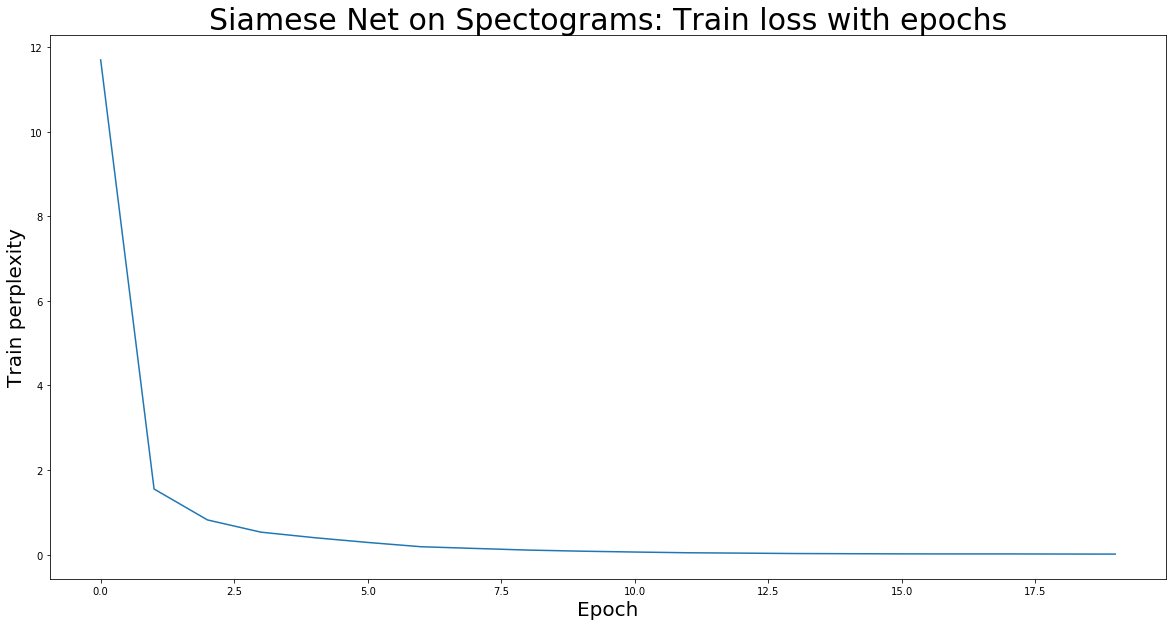

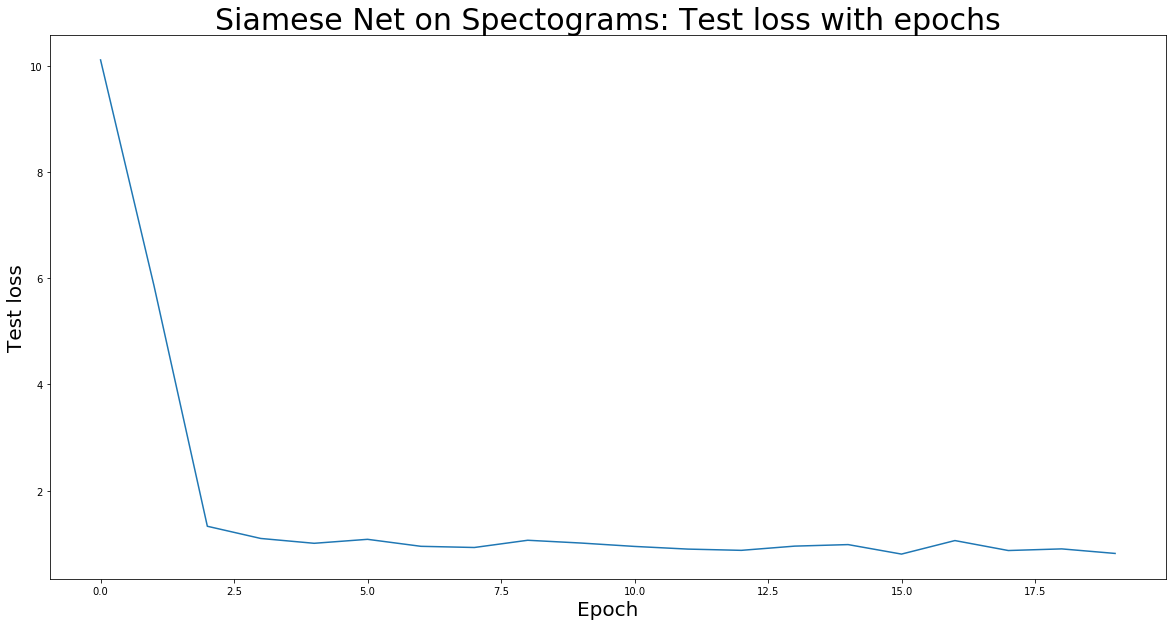

In [35]:
ep, val = zip(*train_losses)
my_plot(ep, val, 'Siamese Net on Spectograms: Train loss with epochs', 'Epoch', 'Train perplexity')
ep, val = zip(*test_losses)
my_plot(ep, val, 'Siamese Net on Spectograms: Test loss with epochs', 'Epoch', 'Test loss')

In [37]:
net

SiameseNetwork(
  (cnn1): Sequential(
    (0): ReflectionPad2d((1, 1, 1, 1))
    (1): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1))
    (2): ReLU(inplace)
    (3): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReflectionPad2d((1, 1, 1, 1))
    (5): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1))
    (6): ReLU(inplace)
    (7): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReflectionPad2d((1, 1, 1, 1))
    (9): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1))
    (10): ReLU(inplace)
    (11): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc1): Sequential(
    (0): Linear(in_features=412232, out_features=500, bias=True)
    (1): ReLU(inplace)
    (2): Linear(in_features=500, out_features=500, bias=True)
    (3): ReLU(inplace)
    (4): Linear(in_features=500, out_features=5, bias=True)
  )
)

In [30]:
torch.save(net.state_dict(), 'siamese_new_20epochs.pt')

## If we need to test this on MNIST too

In [ ]:
from torchvision import datasets, transforms
USE_CUDA = True

use_cuda = torch.cuda.is_available()

torch.manual_seed(SEED)

device = torch.device("cuda" if use_cuda else "cpu")
print('Using device', device)
print('num cpus:', multiprocessing.cpu_count())

kwargs = {'num_workers': multiprocessing.cpu_count(),
        'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                transform=transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Normalize((0.1307,), (0.3081,))
                ])),
    batch_size=BATCH_SIZE, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Normalize((0.1307,), (0.3081,))
                ])),
    batch_size=TEST_BATCH_SIZE, **kwargs)